## Importing libraries

In [71]:
import string

from tensorflow import keras
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import numpy as np

from random import randint
from pickle import load
from keras.models import load_model
from keras_preprocessing.sequence import pad_sequences

## Loading dataset

In [72]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


def return_tokens(doc):
    return doc.split(' ')

# load document
in_filename = 'text_processed.txt'
doc = load_doc(in_filename)
print(doc[:200])

# clean document
tokens = return_tokens(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

# save sequences to file
out_filename = f'sequences{length}.txt'
save_doc(sequences, out_filename)

mr and mrs dursley of number four privet drive were proud to say that they were perfectly normal thank you very much they were the last people youd expect to be involved in anything strange or mysteri
['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'a', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'use

## Tokenizing data and splitting the datasets

In [73]:
# load
in_filename = f'sequences{length}.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state= 8)

## Model creation

In [79]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

# compile model
my_opt = keras.optimizers.Adam(lr=2e-3)
model.compile(loss='categorical_crossentropy', optimizer=my_opt, metrics=['accuracy'])

#constants
batch_size=256
epochs=100

checkpoint_path = "training_1/"

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq = 10*243)
#earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)

# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, shuffle=True, callbacks=[cp_callback])


# save the model to file
model_name = str(batch_size) + '-' + str(epochs) + '.h5'
model.save(model_name)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 50, 50)            300000    
                                                                 
 lstm_40 (LSTM)              (None, 50, 100)           60400     
                                                                 
 lstm_41 (LSTM)              (None, 100)               80400     
                                                                 
 dense_40 (Dense)            (None, 100)               10100     
                                                                 
 dense_41 (Dense)            (None, 6000)              606000    
                                                                 
Total params: 1,056,900
Trainable params: 1,056,900
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
243/243 [=================

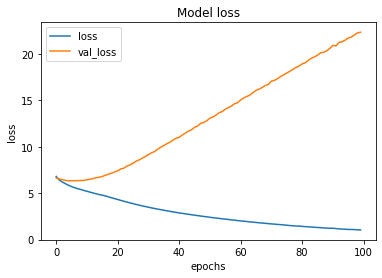

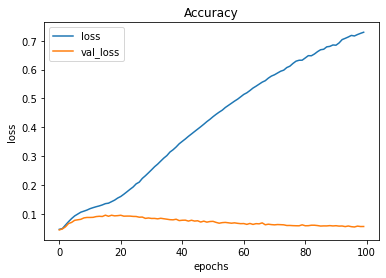

In [80]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model loss')

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Accuracy')
plt.show()

## Generating text

In [ ]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict(encoded)
        yhat_classes = np.argmax(yhat, axis=1)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat_classes:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# load cleaned text sequences
in_filename = 'sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# load the model
model = load_model(model_name)

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')

# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)